In [1]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib inline

In [2]:
text = cv2.imread('../data/text1.jpg')
gray = cv2.cvtColor(text, cv2.COLOR_BGR2GRAY)

## Input Text

Text(0.5, 1.0, 'gray color')

<Figure size 720x720 with 0 Axes>

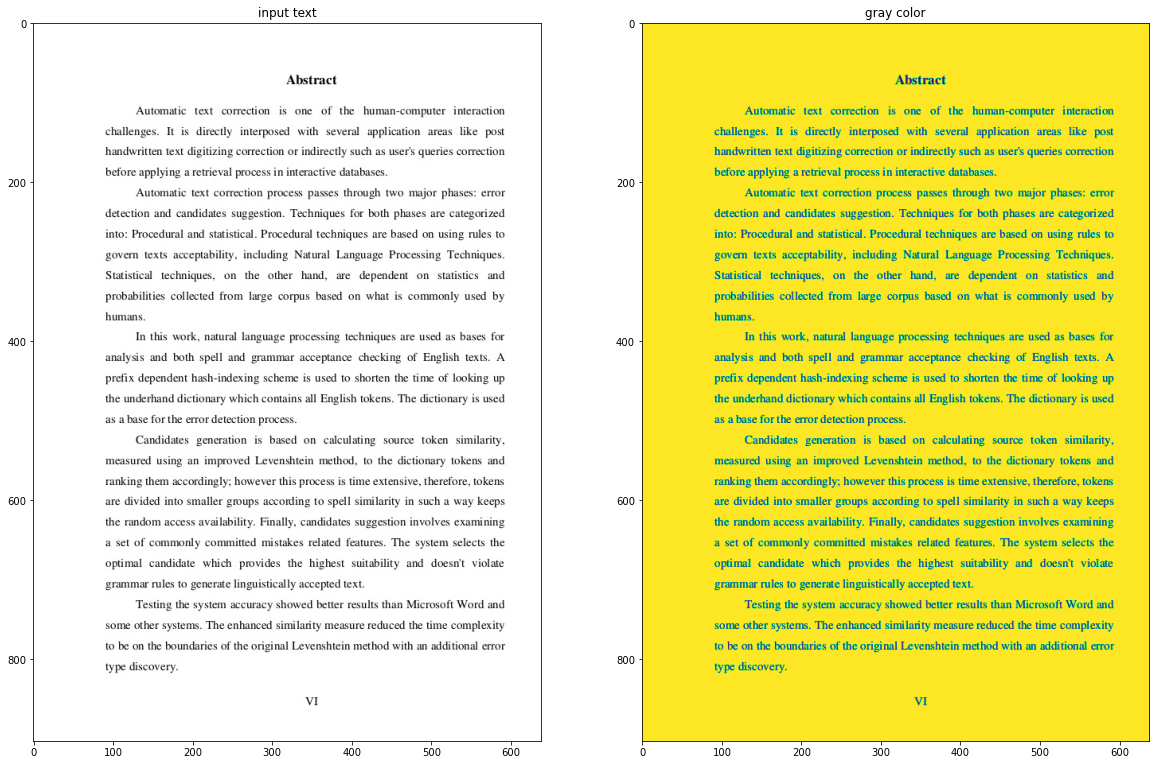

In [8]:
plt.figure(figsize=(10,10))
plt.rcParams["figure.figsize"] = [20,20]

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(text)
ax1.set_title('input text')
ax2.imshow(gray)
ax2.set_title('gray color')

## Read One line assuming we already know where it's located

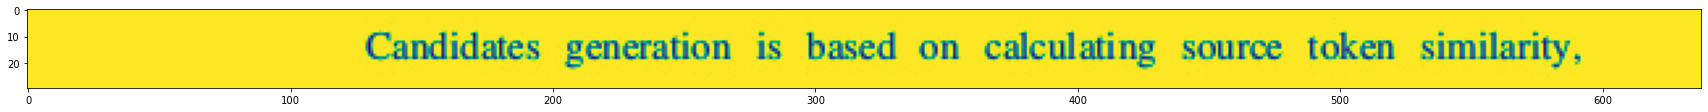

In [11]:
line_interval = [510,540]
plt.figure(figsize=(30,20))

plt.imshow(gray[line_interval[0]:line_interval[1],:])

In [14]:
# Compress the lines vertically into one pixel

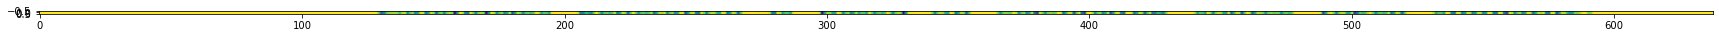

In [16]:
scale_percent = 100 
width = int(gray.shape[1]*scale_percent/100)
height = 1
dim = (width, height)
text_res = cv2.resize(gray[line_interval[0]:line_interval[1],:],dim, interpolation = cv2.INTER_AREA)

plt.figure(figsize=(30,200))

plt.imshow(text_res)

Text(0.5, 1.0, 'Output of compressing lines')

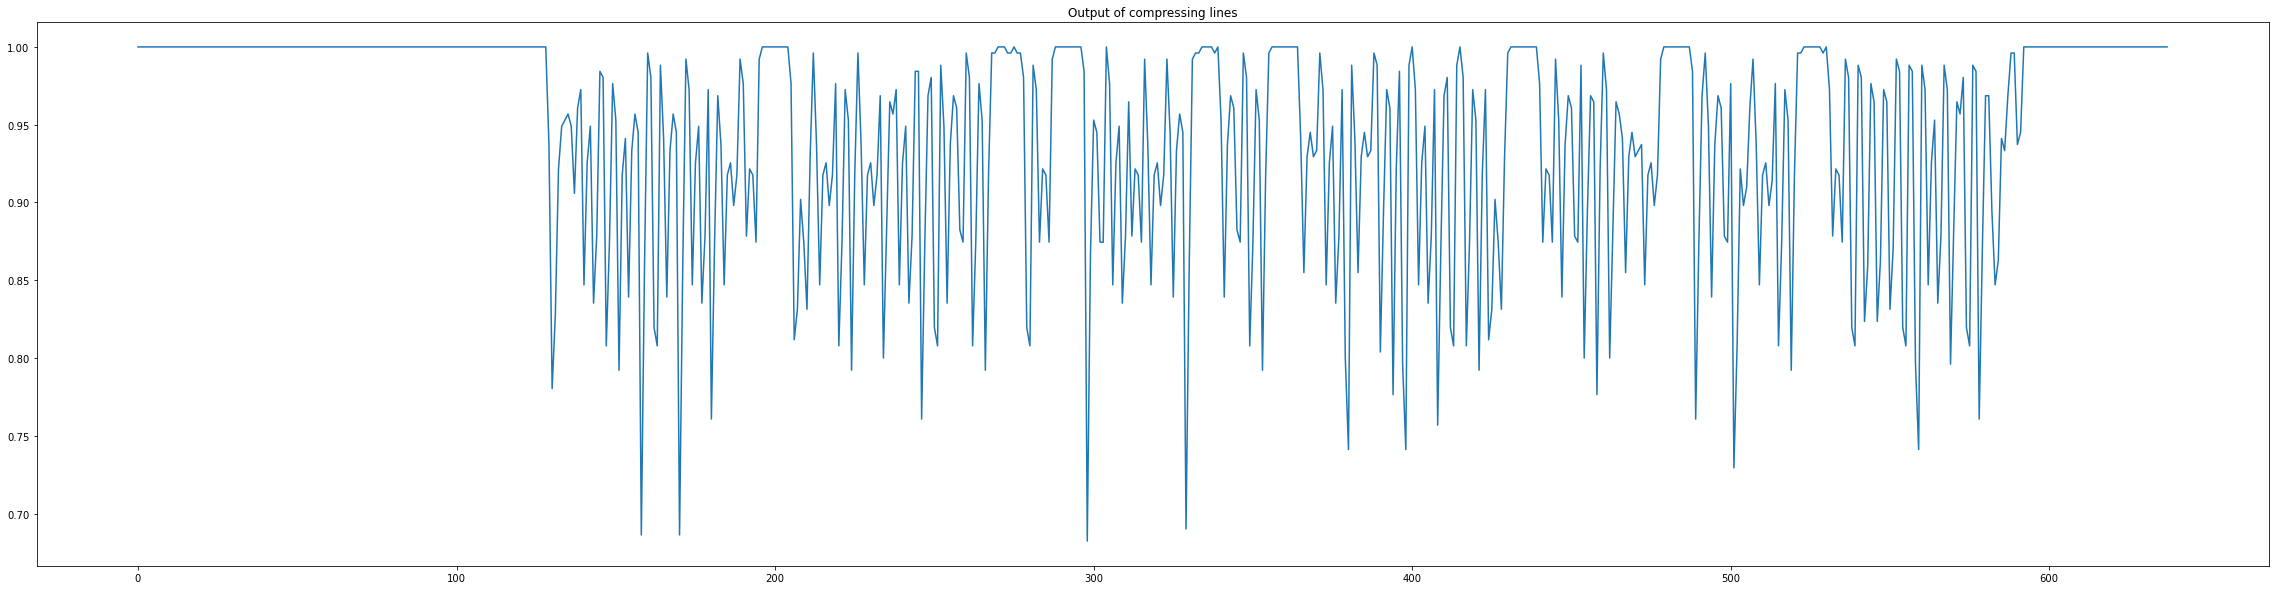

In [20]:
plt.figure(figsize=(40,10))
plt.plot(np.arange(0,text_res.shape[1]),text_res.reshape(-1)/255)
plt.title("Output of compressing lines")

## But first we need to detect each line individually  

To do so, we compress this time the pixels horizonally 

In [24]:
columns = gray.mean(axis = 1)

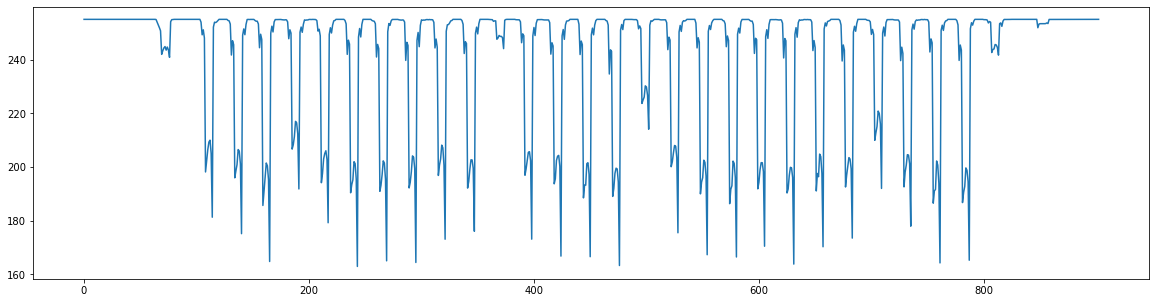

In [25]:
plt.figure(figsize=(20,5))

plt.plot(np.arange(0,columns.shape[0]),columns)

In [26]:
shape = (gray.shape[0],gray.shape[1])

Let's add some noise to the input picture 

In [27]:
noisy_gray = gray + 30*abs(np.random.randn(gray.shape[0],gray.shape[1]))
noisy_gray[int(gray.shape[0]/2):,int(gray.shape[1]/2):] += 30*abs(np.random.randn(gray.shape[0] - int(gray.shape[0]/2),gray.shape[1]-int(gray.shape[1]/2)))

Text(0.5, 1.0, 'filtered noisy image')

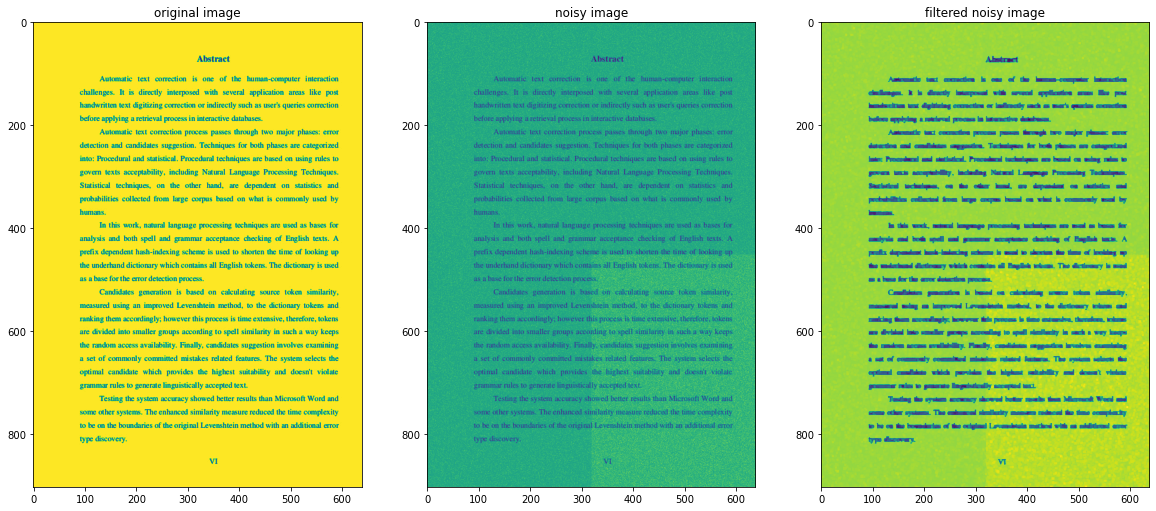

In [28]:
kernel = np.ones((4,4),np.uint8)
morphology = cv2.morphologyEx(noisy_gray, cv2.MORPH_OPEN, kernel)
# cv2.getStructuringElement(gray,cv2.MORPH_OPEN,kernel)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.rcParams["figure.figsize"] = [20,20]

ax1.imshow(gray)
ax1.set_title('original image')

ax2.imshow(noisy_gray)
ax2.set_title('noisy image')

ax3.imshow(morphology)
ax3.set_title('filtered noisy image')


Text(0.5, 1.0, 'filtered noisy image')

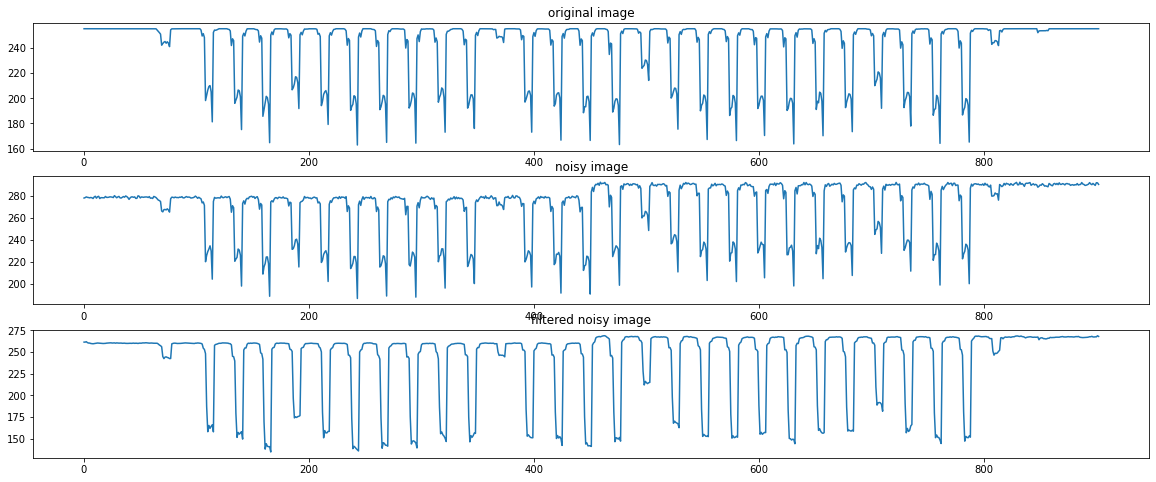

In [29]:
# plt.figure(figsize=(2,2))
plt.rcParams["figure.figsize"] = [20,8]

columns = noisy_gray.mean(axis = 1)

fig, (ax1, ax2 ,ax3) = plt.subplots(3, 1)
ax1.plot(np.arange(0,columns.shape[0]),gray.mean(axis = 1))
ax1.set_title('original image')

ax2.plot(np.arange(0,columns.shape[0]),noisy_gray.mean(axis = 1))
ax2.set_title('noisy image')

ax3.plot(np.arange(0,columns.shape[0]),morphology.mean(axis = 1))

ax3.set_title('filtered noisy image')




Text(0.5, 1.0, 'filtered noisy image')

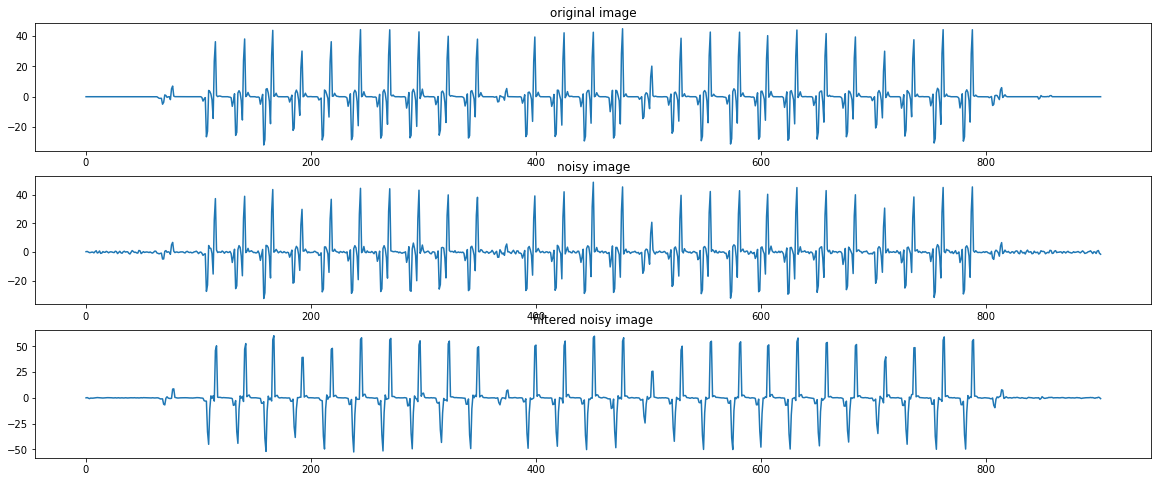

In [30]:
# plt.figure(figsize=(2,2))
plt.rcParams["figure.figsize"] = [20,8]

columns = noisy_gray.mean(axis = 1)

fig, (ax1, ax2 ,ax3) = plt.subplots(3, 1)
ax1.plot(np.arange(0,columns.shape[0]),np.gradient(gray.mean(axis = 1)))
ax1.set_title('original image')

ax2.plot(np.arange(0,columns.shape[0]),np.gradient(noisy_gray.mean(axis = 1)))
ax2.set_title('noisy image')

ax3.plot(np.arange(0,columns.shape[0]),np.gradient(morphology.mean(axis = 1)))
ax3.set_title('filtered noisy image')




## Another way to detect the lines is by using morphological gradient and edge detection to  find the lines

In [83]:
def detect_lines(img):
    """
    Returns lines in a text image, uses opencv to first apply a morphology then findContours to detect the contours of a text.
    Uses the following algorithm for contour detection : 
    Suzuki, S. and Abe, K., Topological Structural Analysis of Digitized Binary Images by Border Following. CVGIP 30 1, pp 32-46 (1985)
    """
    # convert to gray
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else : 
        gray = img.copy()
    # threshold the grayscale image
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # use morphology erode to blur horizontally
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (151, 3))
    morph = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)
    
    # find contours
    cntrs = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntrs = cntrs[0] if len(cntrs) == 2 else cntrs[1]

    # find the topmost box
    ythresh = 1000000
    for c in cntrs:
        box = cv2.boundingRect(c)
        x,y,w,h = box
        if y < ythresh:
            topbox = box
            ythresh = y

    # Draw contours excluding the topmost box
    result = img.copy()
    for c in cntrs:
        box = cv2.boundingRect(c)
        if box != topbox:
            x,y,w,h = box
            cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 2)
    return cntrs,result,morph,thresh

In [84]:
cntrs,result,morph,thresh = detect_lines(text)

Text(0.5, 1.0, 'morphology image')

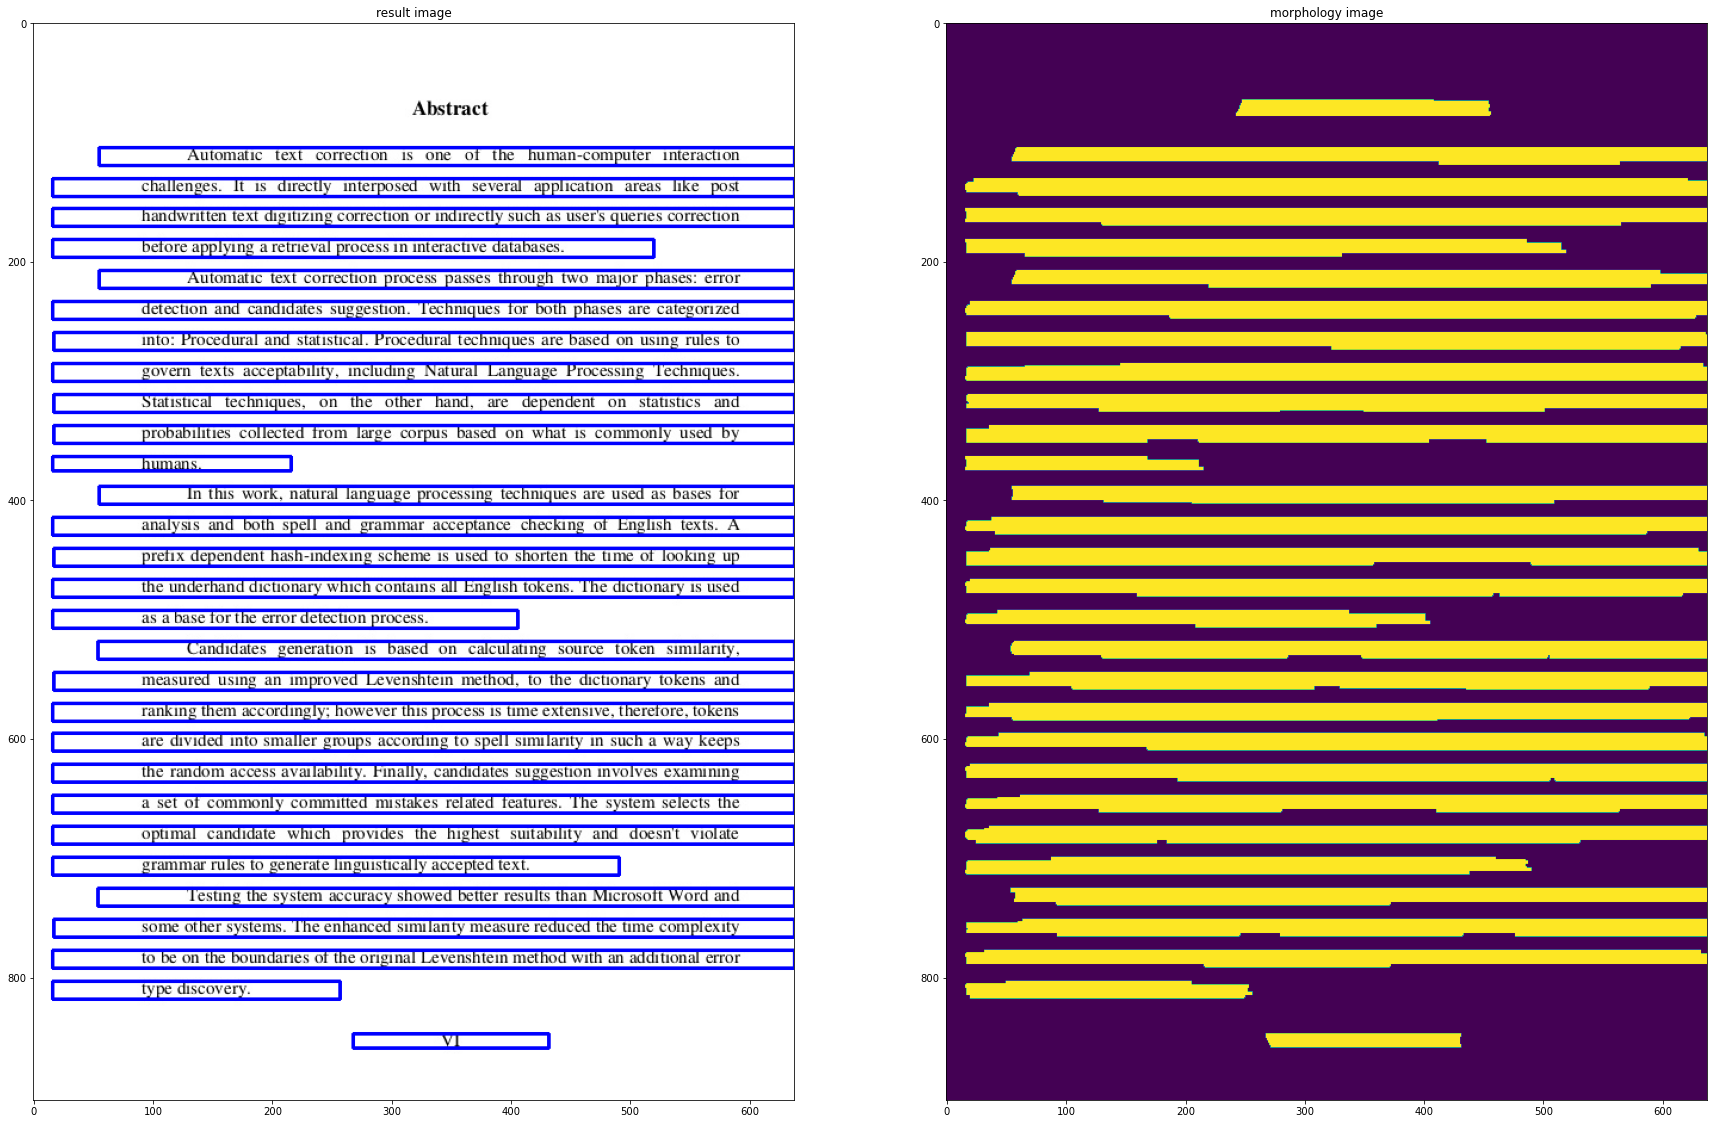

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [30,20]

ax1.imshow(result)
ax1.set_title('result image')

ax2.imshow(morph)
ax2.set_title('morphology image')

### Showing one line 

In [86]:
cntrs[4]

array([[[ 54, 725]],

       [[ 54, 728]],

       [[ 57, 728]],

       [[ 58, 729]],

       [[ 58, 733]],

       [[ 57, 734]],

       [[ 57, 736]],

       [[ 91, 736]],

       [[ 92, 737]],

       [[ 92, 738]],

       [[ 93, 739]],

       [[371, 739]],

       [[372, 738]],

       [[372, 737]],

       [[373, 736]],

       [[637, 736]],

       [[637, 725]]], dtype=int32)

In [179]:
x,y,w,h = cv2.boundingRect(cntrs[4])
x_line2,y_line2,w_line2,h_line2 = cv2.boundingRect(cntrs[3])

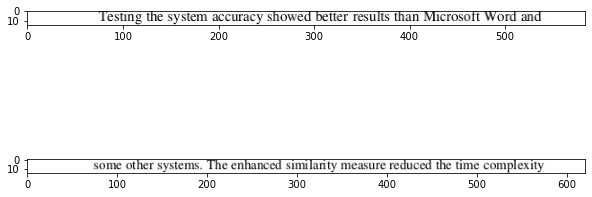

In [181]:
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.imshow(text[y:y+h,x:x+w])
ax2.imshow(text[y_line2:y_line2+h_line2,x_line2:x_line2+w_line2])


In [187]:
print(f'distance between two lines : {y_line2 - y - h } pixels')

distance between two lines : 11 pixels


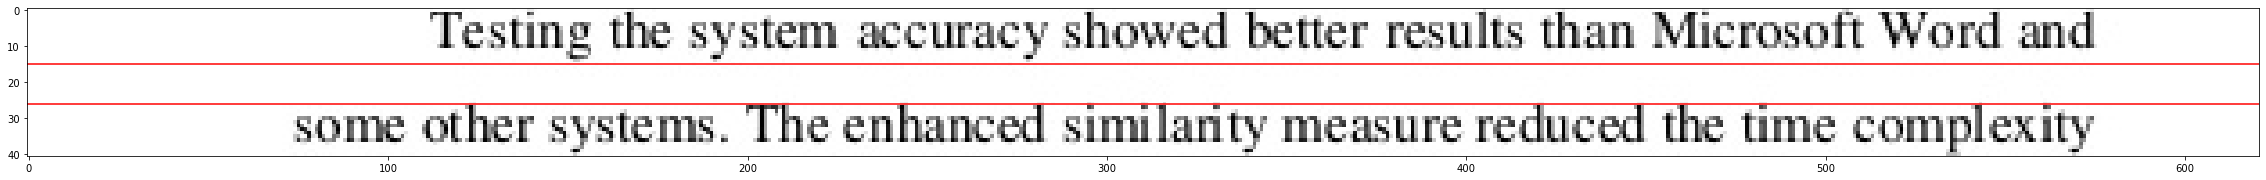

In [212]:
plt.figure(figsize=(40,10))

plt.axhline(y=h, color='r', linestyle='-')
plt.axhline(y=y_line2-y, color='r', linestyle='-')
plt.imshow(text[y:y_line2+h_line2,x_line2:x_line2+w_line2])

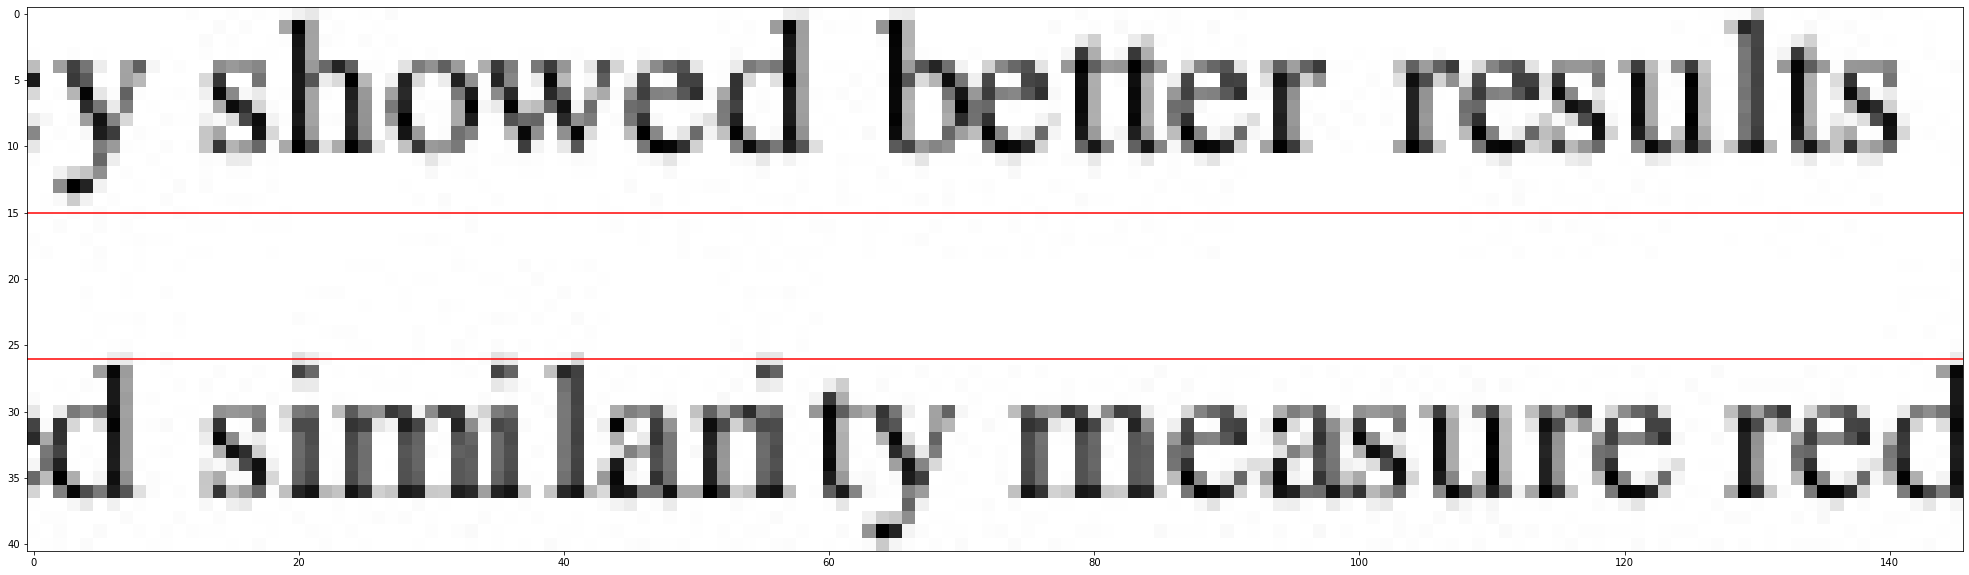

In [211]:
plt.figure(figsize=(40,10))
plt.axhline(y=h, color='r', linestyle='-')
plt.axhline(y=y_line2-y, color='r', linestyle='-')
plt.imshow(text[y:y_line2+h_line2,x_line2+275:x_line2+w_line2-200])

# Let's detect the contours of the words now 

To do so, we transpose one line into a column and we apply the same process

In [131]:
cntrs_columns,one_line,_,_ = detect_lines(gray[y:y+h,x:x+w].T)

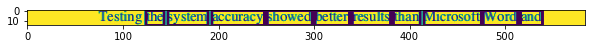

In [177]:
plt.imshow(one_line.T)

#### Isolating two neighbour words 

In [188]:
i = 2
x1,y1,w1,h1 = cv2.boundingRect(cntrs_columns[i+1])
x2,y2,w2,h2 = cv2.boundingRect(cntrs_columns[i])

Text(0.5, 1.0, 'Second word')

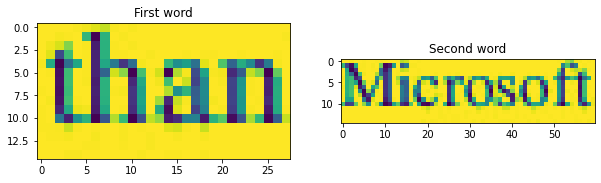

In [189]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.rcParams["figure.figsize"] = [10,5]

ax1.imshow(gray[y:y+h,x:x+w][x1:x1+w1,y1:y1+h1])
ax1.set_title('First word')

ax2.imshow(gray[y:y+h,x:x+w][x2:x2+w2,y2:y2+h2])
ax2.set_title('Second word')


In [190]:
y1,h1,y2

(383, 28, 415)

In [191]:
distance = y2 - (y1 + h1)
print(f'distance between the two words is : {distance} pixels')

distance between the two words is : 4 pixels


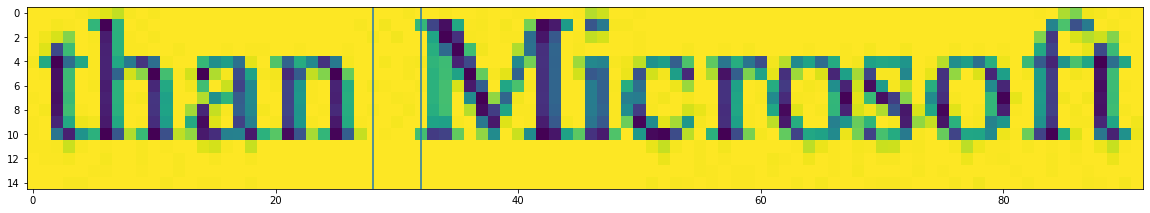

In [221]:
plt.figure(figsize=(20,10))
plt.axvline(x=h1)
plt.axvline(x=y2-y1)


plt.imshow(gray[y:y+h,x:x+w][x2:x2+w2,y1:y2+h2])

We verify that manually 

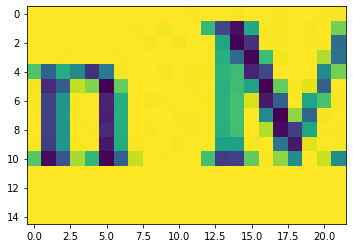

In [224]:
plt.imshow(gray[y:y+h,x:x+w][x2:x2+w2,y1+h1-8:y2+h2-50])

In [ ]:
#vue globale
#+transformations affines
#document a plat, lisible
# redressement de la feuille
# extraction de descripteurs SIFTs OCR
# principalement sur les espaces entre les mots/lignes
# hypothese 1 : 
    #on a le document original
    # puis peut etre considerer que l'on a que les dimensions du document original



In [227]:
import cv2
import pytesseract


# read the image and get the dimensions
img = text.copy()
h, w, _ = img.shape # assumes color image

# run tesseract, returning the bounding boxes


In [229]:
config_str = "-l eng --oem 4 --psm 7"

boxes = pytesseract.image_to_boxes(img, config=("txt "+config_str)) # also include any config options you use

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Yassir\\AppData\\Local\\Temp\\tess_luk5wztw.box'

In [232]:
import csv
import cv2
from pytesseract import pytesseract as pt

pt.run_tesseract('../data/text1.jpg', 'output', lang=None, config="hocr",ext)


TypeError: run_tesseract() missing 1 required positional argument: 'extension'

In [4]:
import pytesseract
from pytesseract import Output
import cv2
img = text.copy()
d = pytesseract.image_to_data(img, output_type=Output.DICT)


In [5]:
n_boxes = len(d['level'])
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2.imshow('img', img)
cv2.waitKey(0)

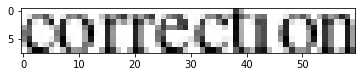

In [20]:
i = 10
plt.imshow(text[d['top'][i]:d['top'][i]+d['height'][i],d['left'][i]:d['left'][i]+d['width'][i]])

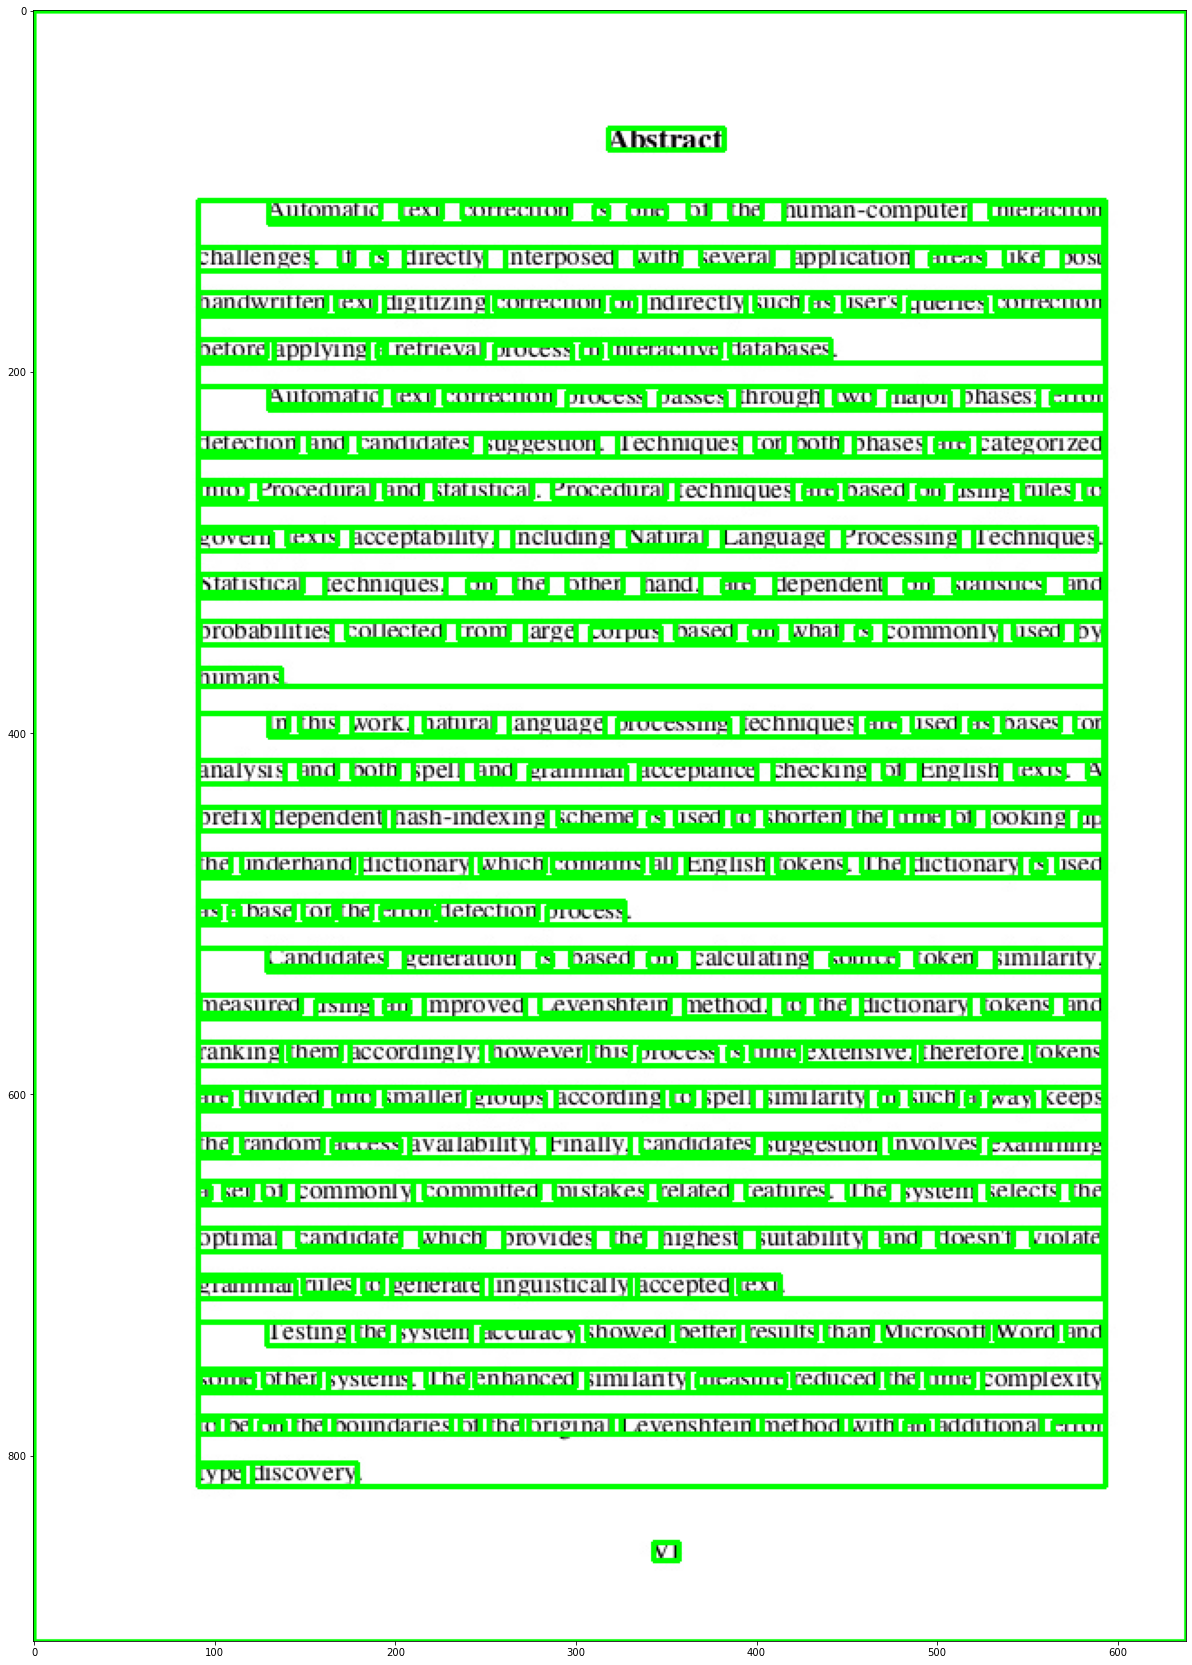

In [8]:
plt.figure(figsize=(40,30))
plt.imshow(img)